In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
"""
Final Project: Action Detection using CNN + LSTM on KTH Dataset
Author: Yasamin Riahi
Date: 2025
Description: This script implements a video action recognition model using CNN for feature extraction
             and LSTM for temporal modeling on the KTH human motion dataset.
"""


import os
import random
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib


# ===============================
# 1. Data Loading and Preprocessing
# ===============================

class KTHDataset(Dataset):
    """
    Custom Dataset class for KTH Action Recognition Dataset.
    Loads video files, extracts frames, and prepares clips for training.
    """
    def __init__(self, root_dir, classes, frames_per_clip=16, resize=(160, 160)):
        self.resize = resize
        self.root_dir = root_dir
        self.classes = classes
        self.frames_per_clip = frames_per_clip
        self.samples = []

        for label, class_name in enumerate(classes):
            class_path = os.path.join(root_dir, class_name)
            for video_file in os.listdir(class_path):
                if video_file.endswith('.avi'):
                    self.samples.append(
                        (os.path.join(class_path, video_file), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = self.load_frames(video_path)
        video_tensor = torch.stack(frames)
        return video_tensor, label

    def load_frames(self, video_path):
        """
        Load and preprocess frames from a video file.
        Uses uniform sampling to select frames.
        """
        cap = cv2.VideoCapture(video_path)
        frames = []

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_idx = 0
        step = max(1, total_frames // (self.frames_per_clip * 2))


        while len(frames) < self.frames_per_clip and frame_idx < total_frames:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            frame_idx += step

            if not ret:
                continue

            try:
                frame = cv2.resize(frame, self.resize)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = torch.from_numpy(frame).float() / 255.0
                frame = frame.permute(2, 0, 1)  # (C, H, W)
                frames.append(frame)
            except:
                continue

        cap.release()

        while len(frames) < self.frames_per_clip:
            frames.append(frames[-1].clone()) if frames else frames.append(torch.zeros(3, *self.resize))

        return frames


def get_dataloaders(root_dir, classes, frames_per_clip, batch_size=4, test_ratio=0.2):
    """
    Create train and test DataLoaders with random split.
    """
    train_samples = []
    test_samples = []

    for label, class_name in enumerate(classes):
        class_path = os.path.join(root_dir, class_name)
        video_files = [f for f in os.listdir(class_path) if f.endswith('.avi')]
        random.shuffle(video_files)

        split_idx = int(len(video_files) * (1 - test_ratio))
        train_files = video_files[:split_idx]
        test_files = video_files[split_idx:]

        train_samples.extend([(os.path.join(class_path, f), label) for f in train_files])
        test_samples.extend([(os.path.join(class_path, f), label) for f in test_files])


    train_dataset = KTHDataset(root_dir, classes, frames_per_clip)
    train_dataset.samples = train_samples

    test_dataset = KTHDataset(root_dir, classes, frames_per_clip)
    test_dataset.samples = test_samples

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
# ===============================
# 2. Model Architecture
# ===============================

class CNN(nn.Module):
    """
    CNN for feature extraction from individual frames.
    """
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x


class ActionLSTM(nn.Module):
    """
    Main model: CNN + LSTM for action recognition.
    """
    def __init__(self, num_classes=3):
        super(ActionLSTM, self).__init__()
        self.cnn = CNN()

        self.lstm = nn.LSTM(
            input_size=128 * 20 * 20,
            hidden_size=256,
            num_layers=1,
            batch_first=True
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        B, T, C, H, W = x.shape

        x = x.view(B * T, C, H, W)
        features = self.cnn(x)
        features = features.view(B, T, -1)

        lstm_out, _ = self.lstm(features)
        out = lstm_out[:, -1, :]
        out = self.fc(out)

        return out

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import joblib


# ===============================
# 3. Training and Evaluation
# ===============================

def train_model(model, train_loader, test_loader, device, num_epochs=20, lr=1e-4):
    """
    Train the model and evaluate on test set after each epoch.
    """
    model = model.to(device)
    weights = torch.tensor([1.0, 1.0, 1.0,2.0,2.4]).to(device)
    cost_function = nn.CrossEntropyLoss(weight=weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_acc = 0.0

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            videos, labels = videos.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(videos)
            loss = cost_function(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)


        test_acc, avg_test_loss = evaluate_model(model, test_loader, device, cost_function)
        test_losses.append(avg_test_loss)
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_acc:.2f}%")
        print(f"Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_model_weights.pth')
            torch.save(model.state_dict(), '/content/drive/MyDrive/KTH_Outputs/best_model_weights.pth')
            print(f"New best model saved with accuracy: {best_acc:.2f}%")

    print(f"Training finished. Best test accuracy: {best_acc:.2f}%")


    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/KTH_Outputs/loss_accuracy_plots.png')
    plt.show()



def evaluate_model(model, loader, device, cost_function=None):
    """
    Evaluate model on given loader.
    """
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for videos, labels in loader:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)

            if cost_function:
                loss = cost_function(outputs, labels)
                total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    avg_loss = total_loss / len(loader) if cost_function else None

    if cost_function:
        return accuracy, avg_loss
    return accuracy



def evaluate_per_class(model, loader, device, classes, save_prefix="final"):
    """
    Detailed per-class evaluation with metrics and confusion matrix.
    """
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for videos, labels in loader:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=classes, digits=3, output_dict=True)
    print(classification_report(all_labels, all_preds, target_names=classes, digits=3))

    metrics = ['precision', 'recall', 'f1-score']
    scores = np.array([[report[cls][m] for m in metrics] for cls in classes])

    plt.figure(figsize=(8, 5))
    x = np.arange(len(classes))
    width = 0.25
    for i, m in enumerate(metrics):
        plt.bar(x + i*width, scores[:, i], width=width, label=m.capitalize())
    plt.xticks(x + width, classes)
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title("Per-Class Metrics")
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{save_prefix}_per_class_metrics.png")
    plt.show()

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f"{save_prefix}_confusion_matrix.png")
    plt.show()

    joblib.dump(report, f"{save_prefix}_metrics.pkl")
    print(f"Reports have been saved successfully")




Epoch 1/25: 100%|██████████| 100/100 [04:49<00:00,  2.90s/it]


Epoch 1/25
Train Loss: 1.5686 | Train Accuracy: 23.31%
Test Loss: 1.4885 | Test Accuracy: 34.00%
New best model saved with accuracy: 34.00%


Epoch 2/25: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 2/25
Train Loss: 1.0605 | Train Accuracy: 40.35%
Test Loss: 1.0285 | Test Accuracy: 47.00%
New best model saved with accuracy: 47.00%


Epoch 3/25: 100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


Epoch 3/25
Train Loss: 0.9322 | Train Accuracy: 42.86%
Test Loss: 1.0040 | Test Accuracy: 45.00%


Epoch 4/25: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


Epoch 4/25
Train Loss: 0.8996 | Train Accuracy: 46.62%
Test Loss: 0.9261 | Test Accuracy: 48.00%
New best model saved with accuracy: 48.00%


Epoch 5/25: 100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


Epoch 5/25
Train Loss: 0.8343 | Train Accuracy: 51.13%
Test Loss: 0.9025 | Test Accuracy: 48.00%


Epoch 6/25: 100%|██████████| 100/100 [01:32<00:00,  1.09it/s]


Epoch 6/25
Train Loss: 0.7632 | Train Accuracy: 54.89%
Test Loss: 0.8335 | Test Accuracy: 57.00%
New best model saved with accuracy: 57.00%


Epoch 7/25: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


Epoch 7/25
Train Loss: 0.7554 | Train Accuracy: 55.14%
Test Loss: 0.8157 | Test Accuracy: 51.00%


Epoch 8/25: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


Epoch 8/25
Train Loss: 0.7014 | Train Accuracy: 60.90%
Test Loss: 0.7170 | Test Accuracy: 68.00%
New best model saved with accuracy: 68.00%


Epoch 9/25: 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


Epoch 9/25
Train Loss: 0.6857 | Train Accuracy: 63.41%
Test Loss: 0.6853 | Test Accuracy: 68.00%


Epoch 10/25: 100%|██████████| 100/100 [01:29<00:00,  1.11it/s]


Epoch 10/25
Train Loss: 0.6393 | Train Accuracy: 64.91%
Test Loss: 0.6749 | Test Accuracy: 66.00%


Epoch 11/25: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 11/25
Train Loss: 0.5989 | Train Accuracy: 70.43%
Test Loss: 0.6136 | Test Accuracy: 76.00%
New best model saved with accuracy: 76.00%


Epoch 12/25: 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


Epoch 12/25
Train Loss: 0.5231 | Train Accuracy: 76.69%
Test Loss: 0.5898 | Test Accuracy: 77.00%
New best model saved with accuracy: 77.00%


Epoch 13/25: 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


Epoch 13/25
Train Loss: 0.4810 | Train Accuracy: 77.69%
Test Loss: 0.5789 | Test Accuracy: 79.00%
New best model saved with accuracy: 79.00%


Epoch 14/25: 100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


Epoch 14/25
Train Loss: 0.4450 | Train Accuracy: 81.45%
Test Loss: 0.5080 | Test Accuracy: 80.00%
New best model saved with accuracy: 80.00%


Epoch 15/25: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


Epoch 15/25
Train Loss: 0.3732 | Train Accuracy: 87.22%
Test Loss: 0.4882 | Test Accuracy: 80.00%


Epoch 16/25: 100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


Epoch 16/25
Train Loss: 0.2890 | Train Accuracy: 88.22%
Test Loss: 0.5113 | Test Accuracy: 80.00%


Epoch 17/25: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 17/25
Train Loss: 0.2276 | Train Accuracy: 91.98%
Test Loss: 0.5015 | Test Accuracy: 78.00%


Epoch 18/25: 100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


Epoch 18/25
Train Loss: 0.2051 | Train Accuracy: 94.49%
Test Loss: 0.5030 | Test Accuracy: 76.00%


Epoch 19/25: 100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


Epoch 19/25
Train Loss: 0.1772 | Train Accuracy: 93.73%
Test Loss: 0.5088 | Test Accuracy: 81.00%
New best model saved with accuracy: 81.00%


Epoch 20/25: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 20/25
Train Loss: 0.1193 | Train Accuracy: 96.99%
Test Loss: 0.5712 | Test Accuracy: 79.00%


Epoch 21/25: 100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


Epoch 21/25
Train Loss: 0.1031 | Train Accuracy: 97.49%
Test Loss: 0.5991 | Test Accuracy: 81.00%


Epoch 22/25: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


Epoch 22/25
Train Loss: 0.0815 | Train Accuracy: 97.99%
Test Loss: 0.5866 | Test Accuracy: 81.00%


Epoch 23/25: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


Epoch 23/25
Train Loss: 0.0574 | Train Accuracy: 98.75%
Test Loss: 0.6209 | Test Accuracy: 81.00%


Epoch 24/25: 100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


Epoch 24/25
Train Loss: 0.0389 | Train Accuracy: 99.75%
Test Loss: 0.6252 | Test Accuracy: 81.00%


Epoch 25/25: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


Epoch 25/25
Train Loss: 0.0376 | Train Accuracy: 99.25%
Test Loss: 0.6425 | Test Accuracy: 81.00%
Training finished. Best test accuracy: 81.00%


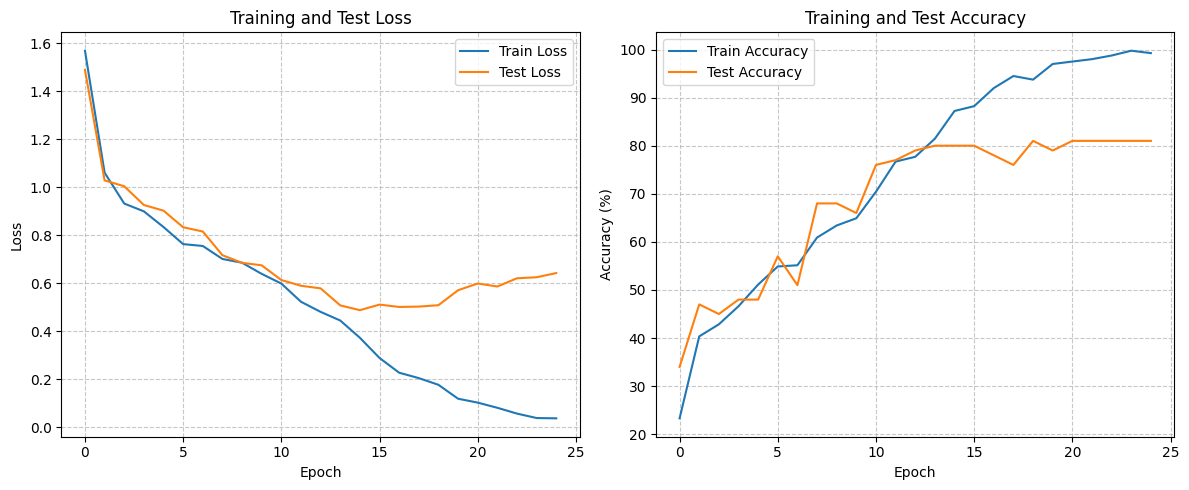

              precision    recall  f1-score   support

      boxing      0.947     0.900     0.923        20
  handwaving      0.692     0.900     0.783        20
     running      0.824     0.700     0.757        20
handclapping      0.933     0.700     0.800        20
     walking      0.739     0.850     0.791        20

    accuracy                          0.810       100
   macro avg      0.827     0.810     0.811       100
weighted avg      0.827     0.810     0.811       100



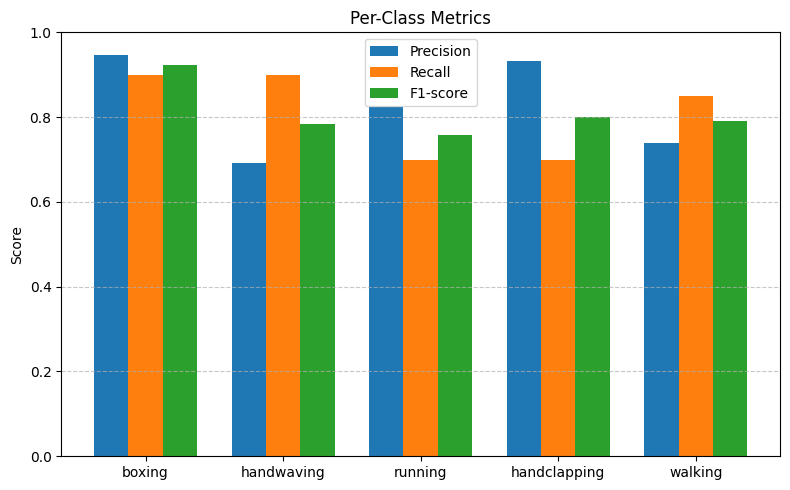

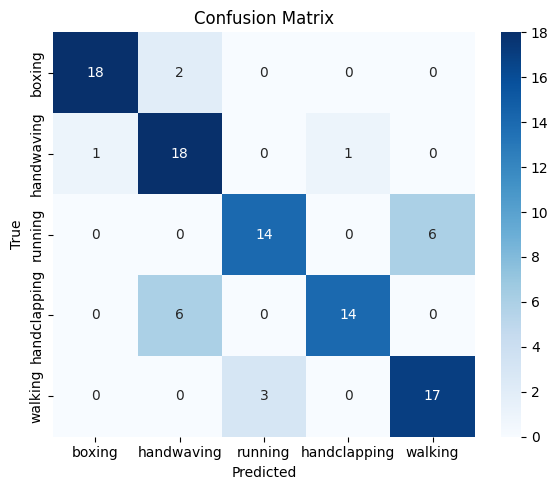

Reports have been saved successfully


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# ===============================
# 4. Main Execution
# ===============================

if __name__ == "__main__":
    INPUT_DIR = '/content/drive/MyDrive/KTH'
    OUTPUT_DIR = '/content/drive/MyDrive/KTH_Outputs'
    CLASSES = ['boxing', 'handwaving', 'running','handclapping','walking']
    FRAMES_PER_CLIP = 16
    BATCH_SIZE = 4
    NUM_CLASSES = len(CLASSES)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, test_loader = get_dataloaders(INPUT_DIR, CLASSES, FRAMES_PER_CLIP, BATCH_SIZE)

    model = ActionLSTM(num_classes=len(CLASSES))

    train_model(model, train_loader, test_loader, device, num_epochs=25, lr=1e-4)

    save_prefix = os.path.join(OUTPUT_DIR, "final_results")

    evaluate_per_class(model, test_loader, device, CLASSES, save_prefix=save_prefix)
